In [898]:
import torch 
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [899]:
class Data():
    def __init__(self, filename):
        data = pd.read_pickle(filename)
        d_time = data.drop(columns=['X'])
        d_pos  = data.drop(columns=['T'])
        x = d_time.iloc[:, :].values
        y =  d_pos.iloc[:, :].values

        self.x = torch.tensor(x, requires_grad=True, dtype=torch.float)
        self.y = torch.tensor(y, requires_grad=True, dtype=torch.float)

    def __len__(self):
        return len(self.x)
    
    def __getparams__(self):
        return self.x, self.y

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


data  = Data('training-oha.pkl')  
vdata = Data('validation-oha.pkl') 
#data.__getparams__()

In [900]:
class OHAModel(nn.Module):
    def __init__(self):
        super(OHAModel, self).__init__()
        self.linear = nn.Sequential(nn.Linear(1, 32), nn.Sigmoid(), nn.Linear(32, 1)) # 1 InputL, 32 HiddenL, 1 OutputL

    def forward(self, x):
        out = self.linear(x)
        return out

model = OHAModel()
print(model)

OHAModel(
  (linear): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [901]:
optimiser = torch.optim.Adam(model.parameters())

In [902]:
# Custom loss function:
# Função base:

class OHALoss(nn.Module):
    def __init__(self):
        super(OHALoss, self).__init__()

    def df(self, output : torch.Tensor, x: torch.Tensor = None, order : int=1) -> torch.Tensor:

        for _ in range(order):
            output = torch.autograd.grad(output, x, grad_outputs=torch.ones_like(x), create_graph=True, retain_graph=True)[0]
            
        return output


    def forward(self, x_physics : torch.Tensor, physics_output : torch.Tensor, BC_output : torch.Tensor, mi, k, amplitude_inicial):
        # DE contribution
        LossDE = self.df(physics_output, x_physics, order=2) + (mi)*self.df(physics_output, x_physics, order=1) + (k)*physics_output 

        #BOUNDARY CONDITION => y0(x0) = y0
        # y0 = 5.0 (de acordo com os dados gerados)
        BC = torch.tensor([amplitude_inicial], dtype=torch.float32)
        LossBC = (BC_output - BC)

        Loss = LossDE.pow(2).mean() + LossBC.pow(2).mean()

        return Loss





In [903]:
loss_func = OHALoss()
x_physics = torch.linspace(0, 10, 300, requires_grad=True).view(-1,1)
x_zero = torch.tensor([0.0], dtype=torch.float32).view(-1,1)

mi = 0.300
k  = 3.240
amplitude_inicial = 1.0

epochs = 20000
for epoch in range(epochs):
    optimiser.zero_grad()

    physics_outputs = model(x_physics)
    BC_output = model(x_zero)

    loss = loss_func(x_physics, physics_outputs, BC_output, mi, k, amplitude_inicial)
    
    loss.backward()
    optimiser.step()
    
    if epoch % 1000 == 0:
         print(f"Epoch: {epoch} - Loss: {float(loss.item()):>7f}")


Epoch: 0 - Loss: 2.927136
Epoch: 1000 - Loss: 0.339521
Epoch: 2000 - Loss: 0.196128
Epoch: 3000 - Loss: 0.136534
Epoch: 4000 - Loss: 0.100475
Epoch: 5000 - Loss: 0.071952
Epoch: 6000 - Loss: 0.049114
Epoch: 7000 - Loss: 0.039594
Epoch: 8000 - Loss: 0.033432
Epoch: 9000 - Loss: 0.028894
Epoch: 10000 - Loss: 0.027063
Epoch: 11000 - Loss: 0.025838
Epoch: 12000 - Loss: 0.024801
Epoch: 13000 - Loss: 0.023803
Epoch: 14000 - Loss: 0.022853
Epoch: 15000 - Loss: 0.021984
Epoch: 16000 - Loss: 0.021238
Epoch: 17000 - Loss: 0.020632
Epoch: 18000 - Loss: 0.020153
Epoch: 19000 - Loss: 0.019770


In [904]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


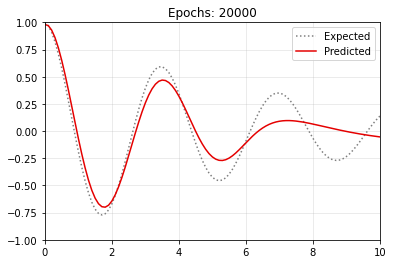

In [909]:
model = OHAModel()
model.load_state_dict(torch.load("model.pth"))

predicted = model(vdata.x)
vx = vdata.x.detach().numpy()
vy = vdata.y.detach().numpy()

x = data.x.detach().numpy()
y = data.y.detach().numpy()

plt.plot(vx, vy, color='tab:gray', linestyle=':', label='Expected')
plt.plot(vx, predicted.detach().numpy(), color='xkcd:red', linestyle='solid', label = 'Predicted')
#plt.plot(x, y, color='xkcd:orange', marker='o', linestyle='none', label = 'Data Provided')
plt.xlim([0, 10])
plt.ylim([-1, 1])
plt.title(f'Epochs: {epochs}')
plt.legend(loc=1)
plt.grid(True, alpha=0.3)
plt.savefig('grafico-oha.jpg')
plt.show()